In [1]:
import numpy as np
import pandas as pd
import pickle

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchvision
from torchvision import models
from torchvision import transforms
from torch.utils.data import WeightedRandomSampler
from torch.optim import Adam, Optimizer

from PIL import Image
import io
import base64
from collections import Counter
import collections
import copy
from tqdm import tqdm
from IPython.display import clear_output

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [2]:
def base64_to_pil_image(image_base64: str) -> Image:
    return Image.open(io.BytesIO(base64.decodebytes(bytes(image_base64, "utf-8")))).convert('RGB')

In [3]:
df = pd.read_csv("dataset.csv")
print(len(df))
df.head()

12743


,Name,image,XID,Kind,City,Rate,Lon,Lat
0,Динамо,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,W38411380,"sport,architecture,historic_architecture,inter...",Екатеринбург,3h,60.600349,56.845398
1,Динамо,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,W38411380,"sport,architecture,historic_architecture,inter...",Екатеринбург,3h,60.600349,56.845398
2,Динамо,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,W38411380,"sport,architecture,historic_architecture,inter...",Екатеринбург,3h,60.600349,56.845398
3,Динамо,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,W38411380,"sport,architecture,historic_architecture,inter...",Екатеринбург,3h,60.600349,56.845398
4,Динамо,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,W38411380,"sport,architecture,historic_architecture,inter...",Екатеринбург,3h,60.600349,56.845398


## В качестве категории для объекта возьмём первую как наиболее точно описывающую данный объект

In [4]:
df['Kind'] = df['Kind'].str.split(',').str[0]

In [5]:
df.head()

,Name,image,XID,Kind,City,Rate,Lon,Lat
0,Динамо,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,W38411380,sport,Екатеринбург,3h,60.600349,56.845398
1,Динамо,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,W38411380,sport,Екатеринбург,3h,60.600349,56.845398
2,Динамо,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,W38411380,sport,Екатеринбург,3h,60.600349,56.845398
3,Динамо,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,W38411380,sport,Екатеринбург,3h,60.600349,56.845398
4,Динамо,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,W38411380,sport,Екатеринбург,3h,60.600349,56.845398


## Категории мест, названия мест

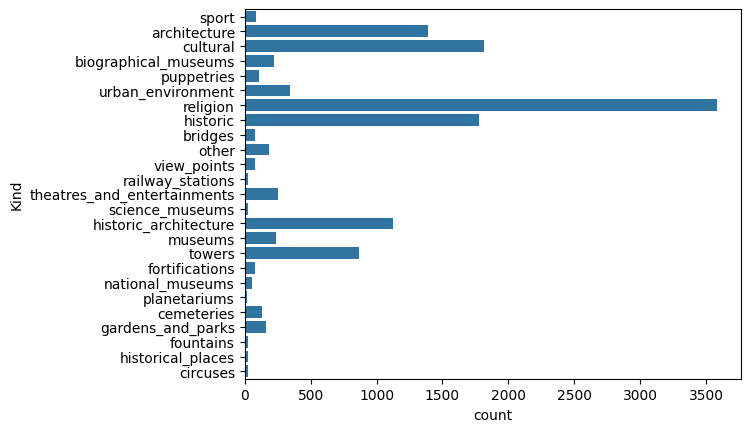

In [6]:
sns.countplot(df['Kind'])
plt.show()

In [10]:
df['Kind'].nunique(), df['Name'].nunique()

(25, 387)

## Разбиение данных на трейн, валидацию и тест

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(df.drop('Name', axis=1),
                                                    df['Name'],
                                                    test_size=0.2,
                                                    stratify=df['Name'],
                                                    random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_temp,
                                                y_temp,
                                                test_size=0.5,
                                                stratify=y_temp,
                                                random_state=42)

train = pd.concat((X_train, y_train), axis=1)
val = pd.concat((X_val, y_val), axis=1)
test = pd.concat((X_test, y_test), axis=1)

In [13]:
train.to_csv("train.csv", index=False)
val.to_csv("val.csv", index=False)
test.to_csv("test.csv", index=False)

In [6]:
train = pd.read_csv("train.csv")
val = pd.read_csv("val.csv")
test = pd.read_csv("test.csv")

In [5]:
train_val = pd.concat((train, val))
train_val.to_csv('train_val.csv', index=False)

## Датасет

In [7]:
cat2ind = {cat: ind for ind, cat in enumerate(np.unique(df['Kind']))}
ind2cat = {ind: cat for cat, ind in cat2ind.items()}

name2ind = {name: ind for ind, name in enumerate(np.unique(df['Name']))}
ind2name = {ind: name for name, ind in name2ind.items()}

In [8]:
# dump dicts

with open('cat2ind.pkl', 'wb') as fp:
    pickle.dump(cat2ind, fp)

with open('ind2cat.pkl', 'wb') as fp:
    pickle.dump(ind2cat, fp)

with open('name2ind.pkl', 'wb') as fp:
    pickle.dump(name2ind, fp)

with open('ind2name.pkl', 'wb') as fp:
    pickle.dump(ind2name, fp)

In [9]:
# open dicts

with open('cat2ind.pkl', 'rb') as fp:
    cat2ind = pickle.load(fp)

with open('ind2cat.pkl', 'rb') as fp:
    ind2cat = pickle.load(fp)

with open('name2ind.pkl', 'rb') as fp:
    name2ind = pickle.load(fp)

with open('ind2name.pkl', 'rb') as fp:
    ind2name = pickle.load(fp)

In [10]:
class PlacesDataset(Dataset):
    def __init__(self,
                 dataset: pd.DataFrame,
                 transforms: transforms.Compose):

        self.images = dataset.image.values
        self.categories = dataset.Kind.values
        self.names = dataset.Name.values
        self.transforms = transforms

        self.cat2ind = cat2ind
        self.ind2cat = ind2cat
        self.name2ind = name2ind
        self.ind2name = ind2name

    def __len__(self):
        return len(self.names)
    
    
    def __getitem__(self, 
                    index: int):
        
        cat = torch.tensor(self.cat2ind[self.categories[index]], dtype=torch.int64)
        name = torch.tensor(self.name2ind[self.names[index]], dtype=torch.int64)
        img = base64_to_pil_image(self.images[index])

        img = self.transforms(img)

        return (img, name, cat)

In [11]:
train_transforms = transforms.Compose(
    [
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [12]:
batch_size = 64

train_dataset = PlacesDataset(dataset=train, transforms=train_transforms)

class_count = Counter(train_dataset.names)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset)
for i, (_, label, _) in enumerate(train_dataset):
    class_weight = class_weights[ind2name[label.item()]]
    sample_weights[i] = class_weight

N = max(class_count.values()) * len(class_count)
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

val_dataset = PlacesDataset(dataset=val, transforms=val_transforms)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)

test_dataset = PlacesDataset(dataset=test, transforms=val_transforms)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [13]:
next(iter(train_loader))

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

## Модель

In [14]:
def get_model() -> nn.Module:

    fe = models.mobilenet_v3_large(pretrained=True)
    fe = nn.Sequential(*list(fe.children())[0][:])

    return fe

In [15]:
class Model(nn.Module):
    def __init__(self,
                 num_cats: int,
                 num_names: int):
        super().__init__()

        self.fe = get_model()

        self.aap = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()

        self.cats = nn.Sequential(
            nn.Linear(960, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),

            nn.Linear(256, num_cats)
        )

        self.names = nn.Sequential(
            nn.Linear(960, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),

            nn.Linear(256, num_names)
        )
        
    def forward(self, x):

        features = self.flatten(self.aap(self.fe(x)))
        out_cats = self.cats(features)
        out_names = self.names(features)

        return out_cats, out_names

In [17]:
model = Model(num_cats=len(cat2ind),
              num_names=len(name2ind))

out = model(torch.rand((3, 3, 224, 224)))

## Функция для обучения модели на одной эпохе

In [18]:
def train_model(model: nn.Module, 
          loader: DataLoader, 
          loss_fn: nn.Module, 
          optimizer: Optimizer,
          device: torch.device) -> tuple[float, float, float]:
    
    model.train()
    train_loss = 0.0
    correct_cats = 0
    correct_names = 0

    for (x, y_names, y_cats) in tqdm(loader):
        x = x.to(device)
        y_cats = y_cats.to(device)
        y_names = y_names.to(device)

        optimizer.zero_grad()

        cats_logits, names_logits = model(x)
        loss1 = loss_fn(cats_logits.to(device), y_cats)
        loss2 = loss_fn(names_logits.to(device), y_names)
        loss = loss1 + loss2

        out_topk_cats = cats_logits.topk(k=5)
        y_cats = y_cats.reshape(-1, 1)
        correct_cats += sum([y_cats[ind] in i  for ind, i in enumerate(out_topk_cats.indices)])

        out_topk_names = names_logits.topk(k=5)
        y_names = y_names.reshape(-1, 1)
        correct_names += sum([y_names[ind] in i  for ind, i in enumerate(out_topk_names.indices)])

        train_loss += loss.item()

        loss.backward()

        optimizer.step()
    
    pr_at_5_cats = correct_cats / (len(loader) * loader.batch_size)
    pr_at_5_names = correct_names / (len(loader) * loader.batch_size)

    return (train_loss / len(loader), pr_at_5_names, pr_at_5_cats)

## Функция для оценки модели

В качестве оценки модели используется метрика precision@5

In [19]:
@torch.inference_mode()
def evaluate_precision_at_5(model: nn.Module,
                            loader: DataLoader,
                            loss_fn: nn.Module,
                            device: torch.device) -> tuple[float, float, float]:

    model.eval()
    val_loss = 0.0
    correct_cats = 0
    correct_names = 0

    for x, y_names, y_cats in tqdm(loader):
        x = x.to(device)
        y_cats = y_cats.to(device)
        y_names = y_names.to(device)

        cats_logits, names_logits = model(x)
        loss1 = loss_fn(cats_logits.to(device), y_cats)
        loss2 = loss_fn(names_logits.to(device), y_names)
        loss = loss1 + loss2
        val_loss += loss.item()

        out_topk_cats = cats_logits.topk(k=5)
        y_cats = y_cats.reshape(-1, 1)
        correct_cats += sum([y_cats[ind] in i  for ind, i in enumerate(out_topk_cats.indices)])

        out_topk_names = names_logits.topk(k=5)
        y_names = y_names.reshape(-1, 1)
        correct_names += sum([y_names[ind] in i  for ind, i in enumerate(out_topk_names.indices)])

    pr_at_5_cats = correct_cats / (len(loader) * loader.batch_size)
    pr_at_5_names = correct_names / (len(loader) * loader.batch_size)

    return (val_loss / len(loader), pr_at_5_names, pr_at_5_cats)

## Функция для вывода графиков обучения (лосс на трейне/валидации, precision@5 для названий и категорий на трейне и валидации)

In [20]:
def plot_stats(train_losses: list,
               pr_names_train: list,
               pr_cats_train: list,
               val_losses: list,
               pr_names_val: list,
               pr_cats_val: list) -> None:
    
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(pr_names_train, label="precision@5 for names on train")
    plt.plot(pr_names_val, label="precision@5 for names on val")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(pr_cats_train, label="precision@5 for categories on train")
    plt.plot(pr_cats_val, label="precision@5 for categories val")
    plt.legend()

    plt.show()

## Функция для всего цикла обучения

In [21]:
def whole_train_valid_cycle(model: nn.Module,
                            train_loader: DataLoader,
                            val_loader: DataLoader,
                            loss_fn: nn.Module,
                            optimizer: Optimizer,
                            device: torch.device,
                            num_epochs: int) -> nn.Module:
    
    train_losses, val_losses, all_pr_cats_train, all_pr_cats_val, all_pr_names_train, all_pr_names_val = [], [], [], [], [], []
    best_avg_pr = 0.0
    best_model = copy.deepcopy(model)

    for epoch in range(num_epochs):

        avg_train_loss, pr_names_train, pr_cats_train = train_model(model=model,
                                                    loader=train_loader,
                                                    loss_fn=loss_fn,
                                                    optimizer=optimizer,
                                                    device=device)
        train_losses.append(avg_train_loss)
        all_pr_names_train.append(pr_names_train)
        all_pr_cats_train.append(pr_cats_train)

        
        avg_val_loss, pr_names_val, pr_cats_val = evaluate_precision_at_5(model=model,
                                                            loader=val_loader,
                                                            loss_fn=loss_fn,
                                                            device=device)
        val_losses.append(avg_val_loss)
        all_pr_names_val.append(pr_names_val)
        all_pr_cats_val.append(pr_cats_val)

        clear_output()
        plot_stats(train_losses=train_losses,
                   pr_names_train=all_pr_names_train,
                   pr_cats_train=all_pr_cats_train,
                   val_losses=val_losses,
                   pr_names_val=all_pr_names_val,
                   pr_cats_val=all_pr_cats_val)
        
        if (pr_names_val + pr_cats_val) / 2 > best_avg_pr:
            best_avg_pr = (pr_names_val + pr_cats_val) / 2
            best_model = copy.deepcopy(model)
    
    return best_model        

In [22]:
def init_wts(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [51]:
model = Model(num_cats=len(cat2ind),
              num_names=len(name2ind)).to(device)

optimizer = Adam(model.parameters(), 
                 lr=3e-4)

model.apply(init_wts)

loss_fn = nn.CrossEntropyLoss()

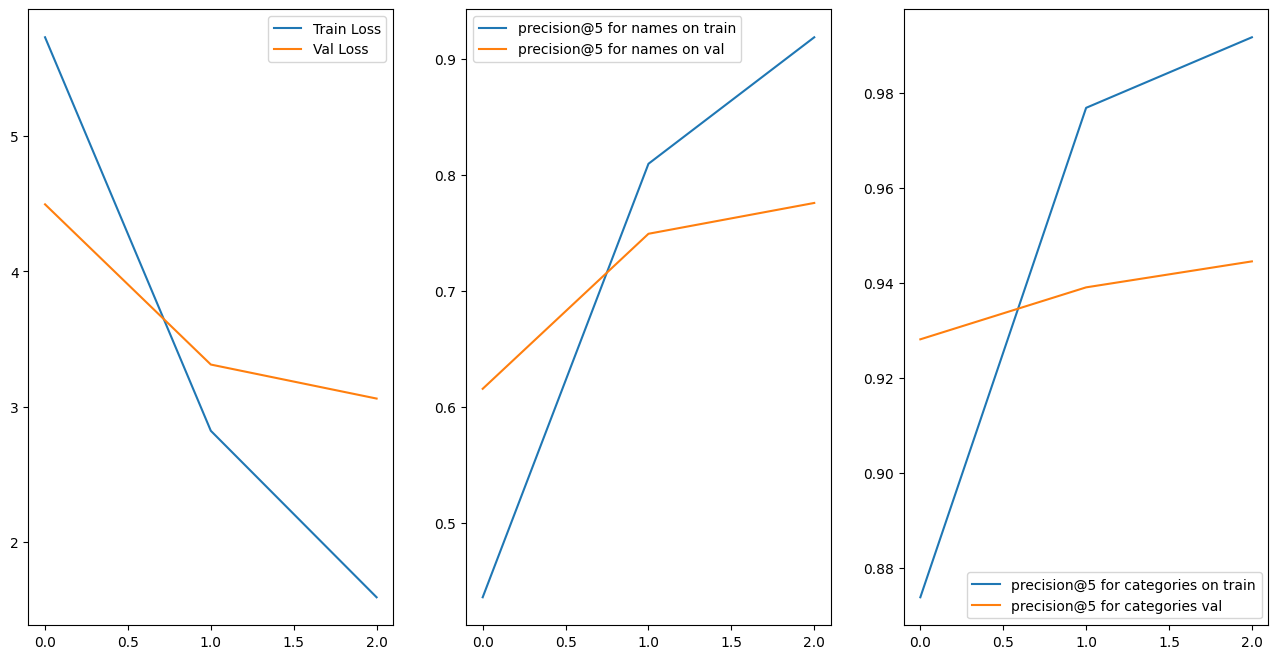

In [38]:
num_epochs = 3

best_model = whole_train_valid_cycle(model=model,
                                     train_loader=train_loader,
                                     val_loader=val_loader,
                                     loss_fn=loss_fn,
                                     optimizer=optimizer,
                                     device=device,
                                     num_epochs=num_epochs)

In [41]:
torch.save(best_model.state_dict(), 'best_wts_cat_names.pt')

In [25]:
model = Model(num_cats=len(cat2ind),
              num_names=len(name2ind)).to(device)

model.load_state_dict(torch.load('best_wts_cat_names.pt'))

<All keys matched successfully>

In [26]:
torch.load('best_wts_cat_names.pt')

OrderedDict([('fe.0.0.weight',
              tensor([[[[-4.8726e-01, -1.9265e-01,  6.9509e-01],
                        [-1.1829e+00, -1.3833e-01,  1.4016e+00],
                        [-5.9234e-01, -8.8378e-02,  6.3593e-01]],
              
                       [[-1.3692e+00, -3.0679e-01,  1.5950e+00],
                        [-2.6854e+00, -3.9641e-01,  3.0071e+00],
                        [-1.4098e+00, -1.8238e-01,  1.7518e+00]],
              
                       [[-2.4068e-01, -6.3447e-02,  1.8358e-01],
                        [-3.3893e-01, -2.8827e-02,  3.7520e-01],
                        [-2.2829e-03, -2.4605e-02,  1.2475e-01]]],
              
              
                      [[[-7.6443e-02,  8.3964e-02, -2.0465e-02],
                        [ 1.8708e-01,  5.3913e-01,  2.5748e-02],
                        [ 4.4494e-02, -3.5341e-03, -5.5990e-02]],
              
                       [[ 1.4063e-01,  4.2316e-01,  3.0535e-01],
                        [ 4.0131e-01,  7.453

## result on validation and test

In [56]:
evaluate_precision_at_5(model, val_loader, loss_fn, device)

100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


(3.0588685989379885, 0.77578125, 0.94453125)

In [57]:
evaluate_precision_at_5(model, test_loader, loss_fn, device)

100%|██████████| 20/20 [00:03<00:00,  5.42it/s]


(3.1534541845321655, 0.7625, 0.94140625)